## Imports

In [1]:
import os
import sys
import polars as pl
import pandas as pd
import numpy as np
import warnings

import lightgbm as lgb
from sklearn.metrics import ndcg_score

warnings.filterwarnings("ignore")

### PATHS

In [2]:
# Processed Data Files
FINALDATA_PATH = '/kaggle/input/hack-inditex-task3-data'
USERS_DATA_PATH = os.path.join(FINALDATA_PATH, 'users_fe.parquet')
TRAIN_PARQUET_PATH = os.path.join(FINALDATA_PATH, 'train_fe.parquet')
TEST_PARQUET_PATH = os.path.join(FINALDATA_PATH, 'test_fe.parquet')
PRODUCTS_PARQUET_PATH = os.path.join(FINALDATA_PATH, 'products_fe.parquet')

In [3]:
SAMPLE = False #only to quick test code

if SAMPLE:
    N_ROWS = 1000000
else:
    N_ROWS = None

In [4]:
train = pl.read_parquet(TRAIN_PARQUET_PATH, low_memory=True, n_rows=N_ROWS)
test = pl.read_parquet(TEST_PARQUET_PATH, low_memory=True)

print(set(train.columns) - set(test.columns))
print(train.shape)
print("Original negative ratio ~15")

{'add_to_cart'}
(46551445, 57)
Original negative ratio ~15


# Filtro solo >5 sessions

In [5]:
# Me quedo con algunas sesiones con MINIMO 5 CART ADDITIONS para validacion
plus5_sessions = train.group_by('session_id').agg(pl.col('add_to_cart').sum()).filter(pl.col('add_to_cart') >= 5)['session_id'].unique().to_list()
train = train.filter(pl.col('session_id').is_in(plus5_sessions))

In [6]:
print(f"Initial target distribution: \n {train['add_to_cart'].value_counts(normalize=True)}")
print(f"Initial size: \n {train.shape[0]}")

Initial target distribution: 
 shape: (2, 2)
┌─────────────┬────────────┐
│ add_to_cart ┆ proportion │
│ ---         ┆ ---        │
│ u8          ┆ f64        │
╞═════════════╪════════════╡
│ 0           ┆ 0.840112   │
│ 1           ┆ 0.159888   │
└─────────────┴────────────┘
Initial size: 
 7748945


In [7]:
DOWNSAMPLE = False
NEG_RATIO = None
DOWN_SEED = 23
CROSSVALIDATE = True

In [8]:
def downsample_data_pl(df: pl.DataFrame, neg_ratio=None, is_train: bool=True, seed=23) -> pl.DataFrame:

    print(f"Initial target distribution: \n {df['add_to_cart'].value_counts(normalize=True)}")
    print(f"Initial negative ratio: \n {(df['add_to_cart'].value_counts()['count'][1]) / (df['add_to_cart'].value_counts()['count'][0])}")
    print(f"Initial size: \n {df.shape[0]}")
    
    if not is_train or neg_ratio == 0:
        return df
    
    # Separate positive and negative cases
    p_cases = df.filter(pl.col('add_to_cart') == 1)
    n_cases = df.filter(pl.col('add_to_cart') == 0)
    
    # Downsample negative cases if neg_ratio is valid
    if neg_ratio is not None and neg_ratio > 0:
        n_negative_samples = int(p_cases.height * neg_ratio)
        n_cases = n_cases.sample(n=n_negative_samples, seed=seed)
    
        df = pl.concat([n_cases, p_cases])
        print("Downsampling...")
        print(f"New target distribution: \n {df['add_to_cart'].value_counts(normalize=True)}")
        print(f"Final size: \n {df.shape[0]}")
    
    return df

if DOWNSAMPLE:
    train = downsample_data_pl(train, neg_ratio=NEG_RATIO, seed=DOWN_SEED)
else:
    NEG_RATIO = "NO"
    DOWN_SEED = "NO"

In [9]:
train.sample(5)

user_id,session_id,partnumber,pagetype,known_user,device_type,country,add_to_cart,page_cart_ratio,device_cart_ratio,country_cart_ratio,user_previous_cart_additions,user_previous_interactions,seconds_since_last_interaction,total_session_time,interaction_length,day_number,weekday_number,hour,day_frame,total_session_interactions,product_interaction_count,discount,color_id,cod_section,family,color_family_frequency,family_discount_rate,section_discount_rate,family_unique_colors,user_country,R,F,M,avg_value_per_purchase,purchase_rate,spend_rate_per_day,total_value_frequency,avg_days_between_purchases,country_avg_monetary,country_avg_frequency,country_avg_recency,relative_monetary_value,relative_frequency,relative_recency,is_high_value_incountry,is_frequent_buyer_incountry,is_recent_customer_incountry,is_high_value,is_frequent_buyer,is_recent_customer,r_segment,f_segment,m_segment,r_rank_in_country,f_rank_in_country,m_rank_in_country
i32,u32,u16,u8,i8,u8,u8,u8,f32,f32,f32,i16,i16,f32,f32,f32,i8,i8,i8,u8,u32,u32,u8,u16,u8,u16,u32,f32,f32,u32,i8,i16,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i8,i8,i8,i8,u8,u8,u8,i32,i32,i32
-1,1723117,6336,8,-1,1,34,1,1.0,0.056601,0.093235,-1,-1,48.0,1256.099976,50.700001,12,3,1,3,31,1,1,83,1,73,4612,0.041197,0.026347,271,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
-1,161415,25009,24,-1,1,29,0,0.053015,0.056601,0.045419,-1,-1,2.6,3916.899902,0.7,12,3,22,2,726,1,0,85,1,153,1448,0.02279,0.026347,187,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
-1,1439340,24680,24,-1,3,34,0,0.053015,0.089953,0.093235,-1,-1,11.3,2798.800049,1.3,11,2,12,1,168,1,0,199,3,156,3446,0.022925,0.074946,279,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
-1,3063921,27416,24,-1,1,34,0,0.053015,0.056601,0.093235,-1,-1,580.700012,2347.300049,14.6,8,6,18,2,111,1,0,83,3,51,3345,0.024813,0.074946,265,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
128352,709299,9962,24,1,1,25,0,0.053015,0.056601,0.066699,1,21,0.8,920.599976,10.1,10,1,15,1,60,1,0,64,1,51,3345,0.024813,0.026347,265,25,40,9,52.168182,5.796465,0.225,1.304205,469.513641,4.444445,42.604546,37.78318,56.788792,1.224475,0.238201,0.704364,1,0,0,0,0,0,2,4,2,171333,415688,133253


In [10]:
test.head()

user_id,session_id,partnumber,pagetype,known_user,device_type,country,page_cart_ratio,device_cart_ratio,country_cart_ratio,user_previous_cart_additions,user_previous_interactions,seconds_since_last_interaction,total_session_time,interaction_length,day_number,weekday_number,hour,day_frame,total_session_interactions,synthetic_candidate,product_interaction_count,discount,color_id,cod_section,family,color_family_frequency,family_discount_rate,section_discount_rate,family_unique_colors,user_country,R,F,M,avg_value_per_purchase,purchase_rate,spend_rate_per_day,total_value_frequency,avg_days_between_purchases,country_avg_monetary,country_avg_frequency,country_avg_recency,relative_monetary_value,relative_frequency,relative_recency,is_high_value_incountry,is_frequent_buyer_incountry,is_recent_customer_incountry,is_high_value,is_frequent_buyer,is_recent_customer,r_segment,f_segment,m_segment,r_rank_in_country,f_rank_in_country,m_rank_in_country
i32,u32,u16,u8,i8,u8,u8,f32,f32,f32,i16,i16,f32,f32,f32,i8,i8,i8,u8,u32,i64,u32,u8,u16,u8,u16,u32,f32,f32,u32,i8,i16,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i8,i8,i8,i8,u8,u8,u8,i32,i32,i32
-1,746,34539,24,-1,1,57,0.053015,0.056601,0.037354,-1,-1,21.171429,148.199997,21.171429,15,6,18,2,7,1,1,0,3,1,146,1420,0.022535,0.026347,103,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
-1,746,12542,24,-1,1,57,0.053015,0.056601,0.037354,-1,-1,21.171429,148.199997,21.171429,15,6,18,2,7,1,1,0,338,1,9,427,0.046838,0.026347,108,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
-1,746,36778,24,-1,1,57,0.053015,0.056601,0.037354,-1,-1,21.171429,148.199997,21.171429,15,6,18,2,7,1,1,0,181,1,51,3345,0.024813,0.026347,265,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
-1,746,39371,24,-1,1,57,0.053015,0.056601,0.037354,-1,-1,21.171429,148.199997,21.171429,15,6,18,2,7,1,1,0,174,1,146,1420,0.022535,0.026347,103,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
-1,746,5910,24,-1,1,57,0.053015,0.056601,0.037354,-1,-1,21.171429,148.199997,21.171429,15,6,18,2,7,1,1,0,64,3,96,225,0.12,0.074946,73,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [11]:
feature_cols = [
 #'partnumber',
 'pagetype',
 'known_user',
 'device_type',
 'country',
 'page_cart_ratio',
 'device_cart_ratio',
 'country_cart_ratio',
 'user_previous_cart_additions',
 'user_previous_interactions',
 'seconds_since_last_interaction',
 'total_session_time',
 'interaction_length',
 'day_number',
 'weekday_number',
 'hour',
 'day_frame',
 'total_session_interactions',
 'product_interaction_count',
 'discount',
 'color_id',
 'cod_section',
 'family',
 'color_family_frequency',
 'family_discount_rate',
 'section_discount_rate',
 'family_unique_colors',
 'user_country',
 'R',
 'F',
 'M',
 'avg_value_per_purchase',
 'purchase_rate',
 'spend_rate_per_day',
 'total_value_frequency',
 'avg_days_between_purchases',
 'country_avg_monetary',
 'country_avg_frequency',
 'country_avg_recency',
 'relative_monetary_value',
 'relative_frequency',
 'relative_recency',
 'is_high_value_incountry',
 'is_frequent_buyer_incountry',
 'is_recent_customer_incountry',
 'is_high_value',
 'is_frequent_buyer',
 'is_recent_customer',
 'r_segment',
 'f_segment',
 'm_segment',
 'r_rank_in_country',
 'f_rank_in_country',
 'm_rank_in_country'
]

cat_cols=[
    ]

# Ranker crossvalidation

## Sampling of 30% of train data
## 20% of this as val data (only sessions with >5 cart additions)

In [12]:
if CROSSVALIDATE:
    from sklearn.model_selection import GroupKFold

    #Only keep 10% of sessions
    cv_sessions = np.random.choice(
        plus5_sessions,  # Use sessions with 5+ additions to match test set 
        size=int(len(plus5_sessions)*0.2),
        replace=False
    )
    train_df = train.filter(pl.col('session_id').is_in(cv_sessions)).to_pandas()
    print("Size of CV data: ", len(train_df))
    
    # Preparar datos para el modelo
    X = train_df[feature_cols+['session_id']]
    y = train_df['add_to_cart']
    groups_cv = train_df['session_id']
    
    # Definir el número de splits para la validación cruzada
    n_splits = 5
    group_kfold = GroupKFold(n_splits=n_splits)
    
    # Crear arrays para almacenar los resultados del entrenamiento
    fold_results = []
    
    # Realizar la validación cruzada
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups=groups_cv)):
        print(f"Fold {fold + 1}")
        
        # Dividir los datos en train y validation según los índices generados por GroupKFold
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
        groups_train = X_train.groupby('session_id').size().values
        groups_val = X_val.groupby('session_id').size().values
    
        X_train.drop('session_id', inplace=True, axis=1)
        X_val.drop('session_id', inplace=True, axis=1)
    
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            X_train, 
            label=y_train,
            group=groups_train,
            free_raw_data=False,
            categorical_feature=cat_cols
        )
        
        val_data = lgb.Dataset(
            X_val,
            label=y_val,
            group=groups_val,
            free_raw_data=False,
            categorical_feature=cat_cols
        )
        
        # Define parameters for LightGBM ranker
        params = {
            'objective': 'lambdarank',
            'metric': 'ndcg',
            'ndcg_at': [5],
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'min_data_in_leaf': 20,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1
        }
        
        # Train model with early stopping
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, val_data],
            valid_names=['train', 'valid'],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(stopping_rounds=10)],
        )
        
        # Calculate NDCG@5 for this fold
        ndcg_score_ = model.best_score['valid']['ndcg@5']
        
        # Store results
        fold_results.append({
            'fold': fold + 1,
            'ndcg@5': ndcg_score_,
            'best_iteration': model.best_iteration
        })
    
    # Print average results across all folds
    avg_ndcg = np.mean([r['ndcg@5'] for r in fold_results])
    avg_iterations = np.mean([r['best_iteration'] for r in fold_results])
    
    print("\nCross-validation results:")
    print(f"Average NDCG@5: {avg_ndcg:.4f}")
    print(f"Average best iterations: {avg_iterations:.0f}")
    
    # Print individual fold results
    print("\nResults by fold:")
    for result in fold_results:
        print(f"Fold {result['fold']}: NDCG@5 = {result['ndcg@5']:.4f}, Best iteration = {result['best_iteration']}")

Size of CV data:  1567785
Fold 1
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	train's ndcg@5: 0.698642	valid's ndcg@5: 0.67104
Fold 2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	train's ndcg@5: 0.695328	valid's ndcg@5: 0.674804
Fold 3
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[126]	train's ndcg@5: 0.691807	valid's ndcg@5: 0.67825
Fold 4
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[227]	train's ndcg@5: 0.706126	valid's ndcg@5: 0.68163
Fold 5
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[186]	train's ndcg@5: 0.700666	valid's ndcg@5: 0.680826

Cross-validation results:
Average NDCG@5: 0.6773
Average best iterations: 167

Results by fold:
Fold 1: NDCG@5 = 0.6710, Best iteration = 163
Fold 2: NDCG@5 = 0.6748, Best iteration

### 0.2 of train sessions:
```plain
Cross-validation results:
Average NDCG@5: 0.6808
Average best iterations: 177

Results by fold:
Fold 1: NDCG@5 = 0.6815, Best iteration = 139
Fold 2: NDCG@5 = 0.6784, Best iteration = 168
Fold 3: NDCG@5 = 0.6818, Best iteration = 184
Fold 4: NDCG@5 = 0.6789, Best iteration = 205
Fold 5: NDCG@5 = 0.6835, Best iteration = 189
```
### All features
```plain
Cross-validation results:
Average NDCG@5: 0.6814
Average best iterations: 165

Results by fold:
Fold 1: NDCG@5 = 0.6798, Best iteration = 121
Fold 2: NDCG@5 = 0.6714, Best iteration = 168
Fold 3: NDCG@5 = 0.6842, Best iteration = 219
Fold 4: NDCG@5 = 0.6897, Best iteration = 173
Fold 5: NDCG@5 = 0.6817, Best iteration = 146
```
### Some to categories
```plain
Cross-validation results:
Average NDCG@5: 0.6773
Average best iterations: 158

Results by fold:
Fold 1: NDCG@5 = 0.6827, Best iteration = 144
Fold 2: NDCG@5 = 0.6810, Best iteration = 128
Fold 3: NDCG@5 = 0.6804, Best iteration = 187
Fold 4: NDCG@5 = 0.6670, Best iteration = 149
Fold 5: NDCG@5 = 0.6754, Best iteration = 180

# Make predictions with last model

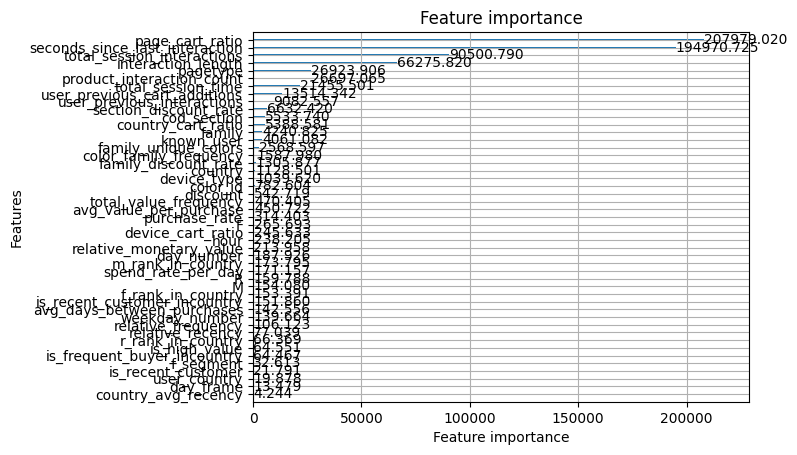

In [13]:
if CROSSVALIDATE:
    lgb.plot_importance(model, importance_type='gain')
    
    import gc
    
    del train_df
    del X_train
    del X_val
    
    # Trigger garbage collection to free memory
    gc.collect()

# Train full model

Only train with +5 cart adition sessions

In [14]:
#train = train.sample(1e6)

In [15]:
val_sessions = np.random.choice(
        plus5_sessions, 
        size=int(len(plus5_sessions)*0.1), 
        replace=False)

train_df = train.filter(~pl.col('session_id').is_in(val_sessions)).to_pandas()
val_df = train.filter(pl.col('session_id').is_in(val_sessions)).to_pandas()
print(train_df.shape, val_df.shape)

(6975227, 57) (773718, 57)


In [16]:
# Preparar datos para el modelo
X_train = train_df[feature_cols]
y_train = train_df['add_to_cart']
groups_train = train_df.groupby('session_id').size().values
print('groups_train', groups_train[:5])

X_val = val_df[feature_cols]
y_val = val_df['add_to_cart']
groups_val = val_df.groupby('session_id').size().values
print('groups_validation', groups_val[:5])

# Create LightGBM datasets
train_data = lgb.Dataset(
    X_train, 
    label=y_train,
    group=groups_train,
    free_raw_data=False
)

val_data = lgb.Dataset(
    X_val,
    label=y_val,
    group=groups_val,
    free_raw_data=False
)

# Define parameters for LightGBM ranker
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_at': [5],
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train model with early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=20)],
)

groups_train [241  17  99  45  57]
groups_validation [29 12 64 33 63]
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[368]	train's ndcg@5: 0.710465	valid's ndcg@5: 0.68975


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

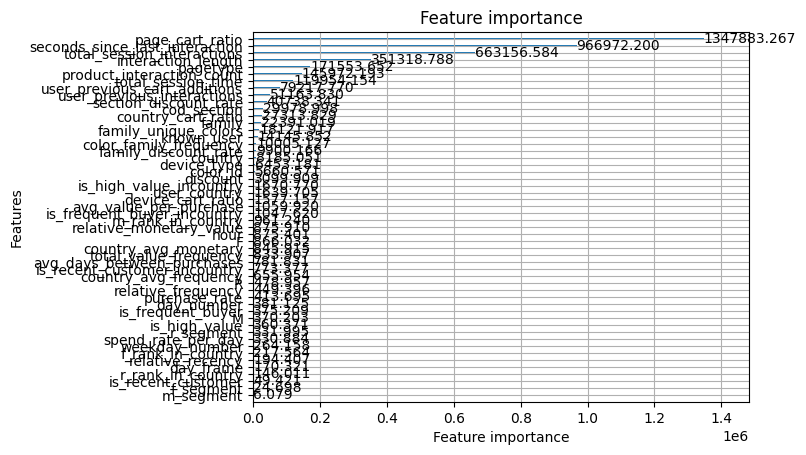

In [17]:
lgb.plot_importance(model, importance_type='gain')

In [18]:
# Save the model including NEG_RATIO and early_stop_rounds in the filename
model_filename = (
    f"lgbmranker_FULL_NEG{NEG_RATIO}_seed{DOWN_SEED}_.txt"
)
model.save_model(model_filename)
#ranker.save_model(model_filename)
print(f"Model saved: {model_filename}")

Model saved: lgbmranker_FULL_NEGNO_seedNO_.txt


In [19]:
# Hacer predicciones en el conjunto de test
val_df['predicted_relevance'] = model.predict(X_val)

# Función para evaluar las predicciones para una query específica
def evaluate_query_predictions(query_df):
    true_relevance = query_df['add_to_cart'].values.reshape(1, -1)
    pred_relevance = query_df['predicted_relevance'].values.reshape(1, -1)
    return ndcg_score(true_relevance, pred_relevance, k=5)

# Evaluamos algunas queries de ejemplo
print("\nEjemplos de rankings predichos:")
for query_id in val_df['session_id'].unique()[:3]:
    query_results = val_df[val_df['session_id'] == query_id].copy()
    query_results = query_results.sort_values('predicted_relevance', ascending=False)
    
    ndcg_5 = evaluate_query_predictions(query_results)
    
    print(f"\nQuery ID: {query_id}")
    print(f"NDCG@5: {ndcg_5:.3f}")
    print("\nTop 5 productos ordenados por relevancia predicha:")
    print(query_results[['user_id', 'session_id', 'partnumber', 'add_to_cart', 'predicted_relevance']]
          .head()
          .to_string())


Ejemplos de rankings predichos:

Query ID: 366034
NDCG@5: 0.301

Top 5 productos ordenados por relevancia predicha:
     user_id  session_id  partnumber  add_to_cart  predicted_relevance
165       -1      366034       10632            0             0.858973
124       -1      366034       33047            0             0.815527
9         -1      366034       16912            1             0.566830
137       -1      366034       36370            0             0.557381
54        -1      366034       34417            1             0.482182

Query ID: 284974
NDCG@5: 0.170

Top 5 productos ordenados por relevancia predicha:
     user_id  session_id  partnumber  add_to_cart  predicted_relevance
226       -1      284974        6032            0             0.759305
206       -1      284974       28288            0             0.692639
241       -1      284974       19505            1             0.604886
150       -1      284974       23653            0             0.454453
174       -1      

# Predict and export predictions

In [20]:
# Hacer predicciones en el conjunto de test
test_pandas = test.to_pandas() # Just in case to retain order
test_pandas['predicted_relevance'] = model.predict(test_pandas[feature_cols])

In [21]:
def predict(test_df, feature_cols, model):
    """
    Hace predicciones en nuevos datos
    """
    test_pandas = test.to_pandas() # Just in case to retain order
    predictions = model.predict(test_pandas[feature_cols])
    
    # Devolver los top 5 productos por sesión
    test_pandas['predicted_score'] = predictions
    
    recommendations = []
    for session_id in test_pandas['session_id'].unique():
        session_preds = test_pandas[test_pandas['session_id'] == session_id]
        top_5 = session_preds.nlargest(5, 'predicted_score')[['session_id', 'partnumber', 'predicted_score']]
        recommendations.append(top_5)
        
    return pd.concat(recommendations)

recommendations = predict(test, feature_cols, model)
print(recommendations.head())

    session_id  partnumber  predicted_score
42         746       26738         2.825188
51         746       25688         2.762497
40         746       42869         2.754540
23         746       20665         2.751449
44         746        9145         2.741379


In [22]:
import json

# Group by session_id and convert partnumbers to a list
grouped = recommendations.groupby('session_id')['partnumber'].apply(list).to_dict()

# Build final JSON dict (session IDs as strings are more standard in JSON)
final_json = {
    "target": {
        str(sess_id): parts for sess_id, parts in grouped.items()
    }
}

with open('predictions_3.json', 'w') as f:
    json.dump(final_json, f, indent=4)

In [23]:
final_json

{'target': {'746': [26738, 25688, 42869, 20665, 9145],
  '1306': [40779, 33528, 3434, 3706, 20351],
  '1364': [40779, 37733, 23268, 24271, 20647],
  '1377': [24387, 21090, 10205, 26999, 24726],
  '2251': [11927, 1205, 25909, 22168, 9391],
  '2344': [40779, 17584, 37733, 2028, 3267],
  '3125': [29642, 32579, 20318, 14937, 31047],
  '4422': [30884, 21687, 41254, 38575, 40789],
  '4711': [373, 39520, 41504, 951, 11927],
  '6621': [18885, 40779, 35939, 7943, 24704],
  '9159': [3951, 20772, 31249, 26510, 28933],
  '9378': [34832, 2272, 36577, 19778, 3089],
  '10758': [1770, 32, 19771, 9444, 980],
  '11913': [47, 35107, 43486, 40779, 40146],
  '14016': [40779, 9296, 37733, 23268, 24271],
  '14252': [5953, 15204, 40265, 36275, 33738],
  '14676': [43593, 40779, 37733, 40982, 13921],
  '15073': [24858, 11927, 1205, 5964, 39520],
  '15472': [5196, 34624, 34938, 5080, 23841],
  '16165': [40779, 37733, 23268, 24271, 20647],
  '16576': [35342, 40779, 9392, 20647, 37733],
  '17015': [40779, 37733, 2